In [12]:
!git clone 'https://github.com/Lorenz92/SKADC1.git'
% cd SKADC1
!echo $PWD

Cloning into 'SKADC1'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 41 (delta 17), reused 25 (delta 6), pack-reused 0
Unpacking objects: 100% (41/41), done.


In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os

import src.dataset as dataset
import src.config as config
from src.utils import *

# from src.config import * 

%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [15]:
for download_info in config.required_files:
    if not os.path.exists(os.path.join(config.TRAIN_DATA_FOLDER, download_info['file_name'])):
        download_data(download_info['file_name'], download_info['url'], config.DOWNLOAD_FOLDER)

In [3]:
# Dataset parsing and loading
# use "subset" to load a small portion of data for development/debugging purposes

ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH, subset=config.DATA_SUBSET)
print(ska_dataset.raw_train_df.shape)
ska_dataset.raw_train_df.head()

(19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


In [4]:
data_560Mhz_1000h_fits = fits.open('./data/training/560Mhz_1000h.fits')
data_PrimaryBeam_B1_fits = fits.open('./data/training/PrimaryBeam_B1.fits')
# data_560Mhz_1000h_fits.info()
data_560Mhz_1000h_fits.filename()

# print(data_560Mhz_1000h_fits[0].data)
# print(data_560Mhz_1000h_fits[0].data.shape)

data_560Mhz_1000h = data_560Mhz_1000h_fits[0].data[0,0]
#data_560Mhz_1000h_fits[0].header

In [5]:
# Visualization test
from astropy.io import fits
from astropy.utils.data import download_file

# image_file = download_file('https://owncloud.ia2.inaf.it/index.php/s/hbasFhd4YILNkCr/download', cache=True )

# image_data = fits.getdata(image_file)
# image_data = image_data.reshape(image_data.shape[2:])

# compute per value to clip the image
perc = 99.9
percentileThresh = np.percentile(data_560Mhz_1000h, perc)
print (f'{perc} percentile {percentileThresh}')

# # crop the image to speed up computation and clip using per value
# image_crop= image_data[5000:10000, 5000:10000]
# image_crop.clip(max=percentileThresh)

# plt.figure(figsize=(100, 100))
# # plt.imshow(normalized_data, cmap='viridis', vmax=255, vmin=0)
# for idx in range(25):
#     plt.subplot(5, 5, idx+1)
#     plt.axis('off')
#     base = 200 * idx
#     end = base + 200
#     normalized_data = image_crop[base:end, base:end] * (1.0 / percentileThresh)
#     plt.imshow(normalized_data, cmap='viridis', vmax=1, vmin=0)

99.9 percentile 8.316711500810925e-06


In [7]:
#ska_dataset_clean = ska_dataset.raw_train_df.drop(ska_dataset.raw_train_df[ska_dataset.raw_train_df.SELECTION > 0].index, inplace=True)
#ska_dataset.remove_rows_by_flux(ska_dataset_clean, data_560Mhz_1000h_fits[0].header,data_PrimaryBeam_B1_fits)
coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header)
print(coords['x1'][0])

19699.88982027529


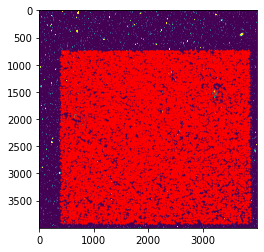

In [16]:

from matplotlib.patches import Rectangle

# data_9200Mhz_1000h_train = data_9200Mhz_1000h[17280:17300, 18800:18820]
data_area_train=data_560Mhz_1000h[16000:20000, 16000:20000]
plt.imshow(data_area_train * (1.0 / percentileThresh), cmap='viridis', vmax=1, vmin=0)
plt.plot(ska_dataset.raw_train_df['x'].apply(lambda x: x - 16000), ska_dataset.raw_train_df['y'].apply(lambda x: x - 16000), 'ro', markersize=1)
# plt.plot(ska_dataset.raw_train_df['x'], ska_dataset.raw_train_df['y'], 'ro', markersize=1)


In [17]:
pd.DataFrame.from_dict(coords)

,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,19699.889820,17708.334874,19709.135520,17717.543623,4.633850,4.593304,5.734349,9.245699,9.208748
1,18314.128617,17121.775102,18488.540079,17200.059688,88.630651,35.798972,3.338082,174.411463,78.284586
2,16490.663037,18502.418816,16496.536575,18510.726749,4.167982,2.916843,4.827354,5.873538,8.307933
3,18019.631633,18181.823147,18020.999232,18182.360119,0.700870,0.220108,6.050027,1.367598,0.536972
4,18124.509296,18597.936034,18127.132703,18603.414392,2.766243,1.253622,4.869573,2.623407,5.478358
...,...,...,...,...,...,...,...,...,...
19217,17592.572752,16742.936603,17593.009233,16743.428821,0.319405,0.078610,0.853117,0.436482,0.492218
19218,18658.822580,18666.464880,18659.100383,18666.968994,0.276376,0.080265,1.127797,0.277803,0.504113
19219,17523.170058,16995.697610,17523.352636,16995.761662,0.093504,0.024824,-0.226387,0.182578,0.064053
19220,16950.523810,17747.923087,16950.979337,17748.452311,0.264791,0.227555,-1.498732,0.455528,0.529224


In [26]:
df_train = ska_dataset._extend_dataframe(ska_dataset.raw_train_df, coords)
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,22923268,-0.469784,-29.846916,-0.469784,-29.846916,4.579590e-08,-0.0,0.047,0.034,47.585,...,17290.068,18810.573179,17290.032021,18810.640098,17290.100855,0.038891,0.028134,0.830515,0.066919,0.068834
1,21867980,-0.359950,-29.521645,-0.359950,-29.521645,5.745240e-08,-0.0,0.109,0.070,-15.109,...,19229.991,18248.990411,19229.924516,18249.167163,19230.045839,0.090195,0.057923,-0.263702,0.176752,0.121323
2,25939522,-0.136767,-29.718441,-0.136767,-29.718441,9.155150e-07,-0.0,0.803,0.346,4.256,...,18060.048,17089.993033,18059.755275,17091.318972,18060.334761,0.664461,0.286306,0.074281,1.325938,0.579486
3,16617483,-0.133707,-29.543222,-0.133707,-29.543222,3.988710e-07,-0.0,0.199,0.095,-78.420,...,19103.965,17075.943351,19103.797290,17076.110959,19104.121460,0.164667,0.078610,-1.368687,0.167608,0.324171
4,26912919,-0.064092,-29.847477,-0.064092,-29.847477,7.125110e-07,-0.0,0.113,0.064,-64.996,...,17291.611,16714.132980,17291.521466,16714.257327,17291.696762,0.093504,0.052958,-1.134394,0.124347,0.175295


----
riga:0 colonna:0
riga:0 colonna:200
riga:0 colonna:400
riga:0 colonna:600
riga:0 colonna:800
riga:0 colonna:1000
riga:0 colonna:1200
riga:0 colonna:1400
riga:0 colonna:1600
riga:0 colonna:1800
riga:0 colonna:2000
riga:0 colonna:2200
riga:0 colonna:2400
riga:0 colonna:2600
riga:0 colonna:2800
riga:0 colonna:3000
riga:0 colonna:3200
riga:0 colonna:3400
riga:0 colonna:3600
riga:0 colonna:3800
----
riga:200 colonna:0
riga:200 colonna:200
riga:200 colonna:400
riga:200 colonna:600
riga:200 colonna:800
riga:200 colonna:1000
riga:200 colonna:1200
riga:200 colonna:1400
riga:200 colonna:1600
riga:200 colonna:1800
riga:200 colonna:2000
riga:200 colonna:2200
riga:200 colonna:2400
riga:200 colonna:2600
riga:200 colonna:2800
riga:200 colonna:3000
riga:200 colonna:3200
riga:200 colonna:3400
riga:200 colonna:3600
riga:200 colonna:3800
----
riga:400 colonna:0
riga:400 colonna:200
riga:400 colonna:400
riga:400 colonna:600
riga:400 colonna:800
riga:400 colonna:1000
riga:400 colonna:1200
riga:400 col

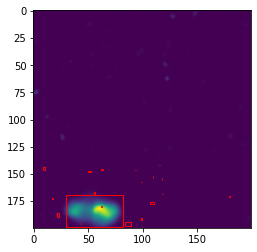

KeyboardInterrupt: Interrupted by user

In [20]:
patches={}
patches = ska_dataset.split_in_patch(data_area_train, df_train, data_560Mhz_1000h_fits.filename(), 200)
#print(len(patches))
# plt.imshow(patches[0] * (1.0 / percentileThresh), cmap='viridis', vmax=1, vmin=0)
# plt.imshow(patches[10] , cmap='viridis')

In [26]:
print(df_train[df_train.x1>16000 and df_train.x1< 16200])

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# First net version
from tensorflow import keras

FROZEN_LAYERS_IDX = [1, 2, 4, 5]
ANCHOR_NUM = 9
PROB_PRED_OUT = 2 * ANCHOR_NUM
COORD_PRED_OUT = 4 * ANCHOR_NUM 

# Load pretrained VGG16 and remove last MaxPool layer
VGG16 = keras.applications.VGG16(include_top=False, input_shape=(600, 600, 3), weights="imagenet")
shared_conv = keras.Model(VGG16.input, VGG16.layers[-2].output, name="Shared Convolutional Net")

# Freeze first 4 convolutional layers
for idx in FROZEN_LAYERS_IDX:
  shared_conv.layers[idx].trainable = False

# Create Region Proposal Net
x = keras.layers.Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu', name='RPN_Conv1')(shared_conv.output)
cls_pred = keras.layers.Conv2D(filters=PROB_PRED_OUT, kernel_size=(1, 1), padding='same', name='RPN_Cls_Conv')(x)
reg_pred = keras.layers.Conv2D(filters=COORD_PRED_OUT, kernel_size=(1, 1), padding='same', name='RPN_Reg_Conv')(x)

region_prop_net = keras.Model(shared_conv.input, [cls_pred, reg_pred], name='Region Proposal')

print(region_prop_net.summary())


ModuleNotFoundError: No module named 'tensorflow'